## Blog Authors Prediction

###  Abstract

Using nltk and spacy, predict the author of blog posts from a corpus of blogs of approximately 200 authors.

### Introduction

Generally, different authors of writings can be distinguished based on the writing style, such as the word choices, sentence lengths, content of the writing, etc. With NLP techniques there is a variety of analyses that can be run on text, both to quantify said features, as well as to take a look at other features of the text as well. I wanted to take a look at how different blogs by different authors were ranked, and see how well the author of posts could be classified or predicted with these methods.

The dataset I used, [Blog Authorship Corpus](https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm), contained posts from 19,320 bloggers. However, I reduced the number to approximately 200 (the exact number varies each time the code is run) blogs for this analysis. In addition to the blog posts and the author, identified by a number, the data contains the zodiac sign of the author, their age, and their industry. 

### Goals

The goals of this project were to 

1. distinguish different features present in the text
2. use these features to predict the author of each blog post

### Imports

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import spacy
from collections import Counter

import re
from sklearn.model_selection import train_test_split

import xml.etree.ElementTree as ET
import os
from time import time


Looking at the blog posts, let's first get the file path and create a list of the filenames to read in from.

# Part 1 - Getting and organizing the data

In [2]:
path_blogs = '/Users/gemma/Documents/data science/blogs/'
blog_files = os.listdir(path_blogs)

In [3]:
# looking at the structure of the filename
blog_files[2]

'3954575.female.23.BusinessServices.Gemini.xml'

Let's see how many blogs we're working with:

In [4]:
len(blog_files)

19320

Next, I'll try to read one blog in and take a look at the structure inside the file.

In [5]:
#file = filenames_BNC[5]   # the BNC

file = path_blogs+blog_files[3] # blogs

#file = path_s+files_s[0]   # sumerian texts

print(file)

# parse the tree and get the root to iterate from later

tree = ET.parse(file)
root = tree.getroot()

/Users/gemma/Documents/data science/blogs/3364931.male.16.Student.Virgo.xml


It looks like there is an issue parsing in the file to the tree due to the character <code>& nbsp;</code>. Let's go through the files, replace all the <code>& nbsp;</code>s with spaces, and then see if it'll work.

Some useful info on reading in files in general and the different modes you can read them in / write them in: [here](https://www.guru99.com/reading-and-writing-files-in-python.html#3).

Also info about how to make the tree from a string was found on [stack overflow](https://stackoverflow.com/questions/647071/python-xml-elementtree-from-a-string-source).

In [6]:
def file_to_string(filename):
    
    f=open(filename, "r") #open the file in read mode. don't change it2 write, otherwise... :D

    if f.mode == 'r': # double check that it's in read mode
        text = f.read() # read the file to the text
    
    space = re.compile('&nbsp;') # this was preventing it from parsing straight from the file
    text = re.sub(space, " ", text) # sub the problem char out with a space
    
    #sometimes & is used as and or is just in the text - accounting for those situations
    
    andd = re.compile('& ')
    text = re.sub(andd, "and ", text) #
    
    randomand = re.compile('&')
    text = re.sub(randomand, "", text)
    
    ugh = re.compile('<>')
    text = re.sub(ugh, "", text)
    
    face = re.compile('>.<')
    text = re.sub(face, "", text)
    
    return text

Let's take a look at all of the elements in the tree.

In [7]:
set([elem.tag for elem in root.iter()])

# another way to look at the structure of the doc: 

#for thing in root.getiterator():
#    print(thing)

{'Blog', 'date', 'post'}

Next, in order to create the dataframe, let's create a function to get the data out of each xml file that has been parsed to a string with the function defined above.

Let's also use the previously used text cleaner function to clean up the text in each post.

In [8]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [9]:
# before using this function, i'll have to remember to define the 3 lists 

def split_data(filename, dates, posts, authors):

    file_as_text = file_to_string(path_blogs+filename)
    #file_as_text = file_to_string(filename)
        
    # since we are going to get the tree from a string and not a file 
    # we can't use ET.parse, and will use the following
    
    tree = ET.ElementTree(ET.fromstring(file_as_text))
    root = tree.getroot()

    for post_date in root.findall('date'):
        
        # replace the , with . so the structure is consistent
        date_split = re.sub(r",", "-", post_date.text)
        dates.append(date_split)
        
        authors.append(filename)
        
    for post_itself in root.findall('post'):
        
        cleaned = text_cleaner(post_itself.text)
        posts.append(cleaned)
    
    return 

We'll pick 250 files randomly to try to read in data from, to use in the dataframe. Then we'll have extra files in case a significant amount of them have errors and can't be read in on a first try. 

In [10]:
selected = np.random.choice(blog_files,250)

<em>Info about error handling from [here](https://docs.python.org/3/tutorial/errors.html)</em>

In [11]:
# the lists (and 1 dict) are 

dates = []
posts = []
authors = []

count = 0

for i, file in enumerate(selected):
    try:
        split_data(file, dates, posts, authors)    
    except:
        #UnicodeDecodeError:
        #print('Error with {}'.format(i))
        count+=1
    
print('error count = {}'.format(count))

error count = 15


In [12]:
# make a dictionary from authors to create the dataframe from there

author_dict = {}

for i, value in enumerate(authors):
    separated = value.split(".")
    author_dict[i] = separated[:-1]


In [13]:
df = pd.DataFrame.from_dict(data=author_dict, orient='index', columns=['author_id', 'gender', 
                                                       'age', 'industry', 'sign'] )

df['date'] = dates
df['post'] = posts

In [14]:
df.head()

,author_id,gender,age,industry,sign,date,post
0,1979283,male,27,Internet,Aries,24-May-2004,funny how 10 minutes seem like forever...i nee...
1,1979283,male,27,Internet,Aries,24-May-2004,Had problems posting again. Thanks to the peop...
2,1979283,male,27,Internet,Aries,24-May-2004,Finally got this to work..so here's my first w...
3,1979283,male,27,Internet,Aries,24-May-2004,I've been spending many hours getting my ears ...
4,1979283,male,27,Internet,Aries,24-May-2004,Getting this SEO shit up is really getting on ...


After separating and re combining the data into the dataframe, I'll use spacy to parse the blog posts.

In [15]:
nlp = spacy.load('en_core_web_lg')

df['parsed'] = df['post'].apply(nlp)

I found that some of the months are not in English, which leads to the assumption that some of the posts are not in English. Originally I just replaced the months with the english but the analysis of the text won't work since we are only loading the English language.

I'll use Google Cloud API to check the language of each row, and then drop rows that aren't in English. I used these resources: [Translation API Client Libraries](https://cloud.google.com/translate/docs/reference/libraries) (and [explicitly adding credentials](https://cloud.google.com/docs/authentication/production)) and [Detecting the lang of a string](https://cloud.google.com/translate/docs/detecting-language#translate_detect_language-python) . 

Another resource - [lang detect](https://pypi.org/project/langdetect/).

In [16]:
#export GOOGLE_APPLICATION_CREDENTIALS="""/Users/gemma/Documents/data science/DS Bootcamp/
#                                         My First Project-901fbdcc624d.json"""

# Imports the Google Cloud client library
from google.cloud import translate

# Instantiates a client
translate_client = translate.Client.from_service_account_json(
        '/Users/gemma/Documents/data science/DS Bootcamp/My First Project-901fbdcc624d.json')


In [17]:
# running this on the whole sries made me hit the quota on the79th row, so im
# just going to look at the first 50 char of each post

def check_fifty_char(series):
    return translate_client.detect_language(series[:15])

df['lang'] = df['post'].apply(check_fifty_char)


In [18]:
def check_lang(series):
    if series['language'] != "en":
        series = np.nan
    return

# substitute non english with NaN
df['lang'].apply(check_lang)

# drop the rows of NaN - can't use non English data in this analysis 
df.dropna(axis=0, how='any', inplace=True)


In [19]:
# now that we're done with the language column, let's drop it 

df.drop('lang', axis=1, inplace=True)

In [20]:
# someone has julio, agosto, and maj in their date but the post is still in english
df[df['date'].str.contains("maj")]

,author_id,gender,age,industry,sign,date,post,parsed


Even after checking the language, and dropping all non English posts, some of the months are still spelt incorrectly and are causing errors. I double checked the erroneous rows to make sure the posts were in English, and then I will replace the strings that flag as errors when trying to run cell 94 below.

In [21]:
# some months either in other langs (which will bring some other issues later on) or 
# just spelled wrong
replacing = {"Mai":"May", "mayo": "May", "mei": "May", "Agosto":"August", "juli":"July", 
             "Julho":"July", "Juli":"July", "mars":"March", "juni": "June", "Juni":"June", 
             "augustus": "August", "agosto":"August", 'augusti':'Agusut', "Agusut":"August",
            "Dezember": "December", "Januar": "January", "Januaryy": "January",
            "Januaryy": "Jan", "Jany": "Jan", "Februar": "Feb", "Feby": "Feb",
              "julio": "July", "maj": "May", "juni": "June", "juin": "June", "juillet":"July"}
                            
for k in replacing.keys():
    df['date'] = df['date'].str.replace(k,replacing[k],regex=False)

In [22]:
df['date'] = pd.to_datetime(df['date'])

In [23]:
df['month'] = df['date'].dt.month

In [24]:
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year

In [25]:
df['gender'] = np.where(df['gender'] == 'male', 1, 0)

#binarize gender since only male or female are options here

In [26]:
df.head(3)

,author_id,gender,age,industry,sign,date,post,parsed,month,day,year
0,1979283,1,27,Internet,Aries,2004-05-24,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,24,2004
1,1979283,1,27,Internet,Aries,2004-05-24,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,24,2004
2,1979283,1,27,Internet,Aries,2004-05-24,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '...",5,24,2004


## Part 1.2 - Features

I'll binarize the categorical data (indsustry and sign), drop the redundant columns, and create some new features.

In [27]:
binned = pd.get_dummies(df.loc[:,['industry','sign']])

df = pd.concat([df.drop(['industry','sign','date'], 1), 
                     binned], axis=1) 


In [28]:
df.head(2)

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,sign_Cancer,sign_Capricorn,sign_Gemini,sign_Leo,sign_Libra,sign_Pisces,sign_Sagittarius,sign_Scorpio,sign_Taurus,sign_Virgo
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,24,2004,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,24,2004,0,0,...,0,0,0,0,0,0,0,0,0,0


For features, I'll add a word count, a vector of the entire blog post, a pronoun count per post, and then use Bag of Words and add the most common 150 words as features as well.

In [29]:
df["word_count"] = len(df['parsed'])

In [30]:
# getting vectors with spacy, will also get vectors with unsupervised methods later on

def get_post_vector(post):
    span = post
    if span.has_vector:
        return span.vector_norm
    else:
        return 0

df['vector'] = df['parsed'].apply(get_post_vector)

In [31]:
def get_pron_count(text):
    count = 0
    for token in text:
        if token.pos_ == "PRON":
            count+=1
    return count

df['pronoun_count'] = df['parsed'].apply(get_pron_count)

Bag of Words

In [32]:
def bag_of_words(text, all_words):
    
    # Filter out punctuation and stop words.
    all_words += ([token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop])
    
    # Return the most common words.
    #return [item[0] for item in Counter(allwords).most_common(1000)]
    
all_words = []
df['parsed'].apply(bag_of_words, args=(all_words,))

print(len(all_words))

common_words = [item[0] for item in Counter(all_words).most_common(150)]

1226502


In [33]:
df.head(2)

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,sign_Leo,sign_Libra,sign_Pisces,sign_Sagittarius,sign_Scorpio,sign_Taurus,sign_Virgo,word_count,vector,pronoun_count
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,24,2004,0,0,...,0,0,0,0,0,0,0,6121,3.630934,1
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,24,2004,0,0,...,0,0,0,0,0,0,0,6121,3.273414,3


In [34]:
for word in common_words:
    df[word] = 0
    
for i, sentence in enumerate(df['parsed']):
        
        # I already converted the sentence to lemmas, and filtered out punctuation and stop words.
        # Now I'm just going to get a list of the words in each line that are in the common words list.
        words = [token.lemma_
                 for token in sentence
                 if token.lemma_ in common_words
                ]
        
        # Populate the row with word counts
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000


In [35]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,maybe,school,ask,play,watch,keep,write,another,many,man
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1979283,1,27,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '...",5,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,1979283,1,27,I've been spending many hours getting my ears ...,"(I, 've, been, spending, many, hours, getting,...",5,0,1,0,0,...,0,0,0,2,0,0,0,0,1,0
4,1979283,1,27,Getting this SEO shit up is really getting on ...,"(Getting, this, SEO, shit, up, is, really, get...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now the dataframe is quite large. I'm going to go through and create a correlation matrix, and then drop words with high correlations (over 90%).

In [36]:
corr_m = df.drop(['post', 'parsed'],1).corr()

In [37]:
flds = corr_m.columns.values

to_drop = []

for i in range(corr_m.shape[1]):
    for j in range(i+1, corr_m.shape[1]):
        if corr_m.iloc[i,j] > 0.90:
            if flds[i] not in to_drop:
                to_drop.append(flds[i])


#even = range(len(to_drop)-1, 0,-2)

#for i in even:
#    to_drop.remove(to_drop[i])
print(to_drop)

['pronoun_count']


In [38]:
# let's drop them

df.drop(to_drop,1, inplace=True)

In [39]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,maybe,school,ask,play,watch,keep,write,another,many,man
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1979283,1,27,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '...",5,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,1979283,1,27,I've been spending many hours getting my ears ...,"(I, 've, been, spending, many, hours, getting,...",5,0,1,0,0,...,0,0,0,2,0,0,0,0,1,0
4,1979283,1,27,Getting this SEO shit up is really getting on ...,"(Getting, this, SEO, shit, up, is, really, get...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 2 - Test set

Reserve 25% of the corpus as a test set.


In [40]:
X = df.drop(['author_id','post','parsed'], 1)
Y = df['author_id']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)



<hr width="50%"/>

# Part 3 - Clustering

The clustering algorithms I'm going to use - K means and mean shift - require normalized data, which will be the next step. 

In [41]:
from sklearn.preprocessing import normalize

In [42]:
X_train_norm = normalize(X_train)

## Clustering - K Means


In [43]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

I'll try k means with different values for n, number of clusters. First I'm trying this with 5 clusters.

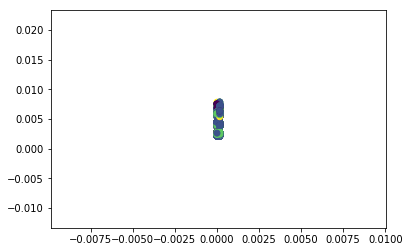

Time: 1.3337719440460205 seconds 
Comparing k-means clusters against the data:
author_id  1090547  1110391  1135724  1197086  1363719  1486619  1496664  \
row_0                                                                      
0                0        5        4        0        6        0        6   
1                1       22       21        2       58       39       28   
2                0        0        1        0        2        0        2   
3                0       26       17        2       24        2       16   
4                0        0        0        0        0        0        1   

author_id  1533236  1594483  1627914  ...   4305123  4312837  4322781  \
row_0                                 ...                               
0                3       23        4  ...         0        1        1   
1               10       16       38  ...         1        0        0   
2                0        3        0  ...         1        0        0   
3                4     

In [44]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

This looks pretty good, at most an author is spread across 3 clusters, with 1 or 2 being the average. Let's try another amount of clusters to see if performance can be improved. I tried 2 clusters already and it was less effective.

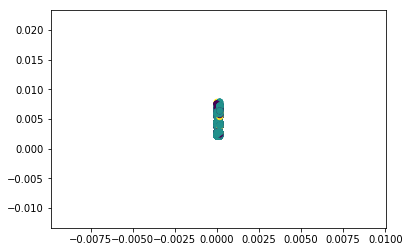

Time: 1.2750308513641357 seconds 
Comparing k-means clusters against the data:
author_id  1090547  1110391  1135724  1197086  1363719  1486619  1496664  \
row_0                                                                      
0                0       14        8        0       17        0       12   
1                1       39       35        4       73       41       39   
2                0        0        0        0        0        0        2   

author_id  1533236  1594483  1627914  ...   4305123  4312837  4322781  \
row_0                                 ...                               
0                4       50       10  ...         2        1        1   
1               13       53       50  ...         2        0        0   
2                0        3        0  ...         0        0        0   

author_id  4323865  4325889  483266  574985  579034  851693  9289  
row_0                                                              
0                1        0       0   

In [45]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_train_norm)

#km = KMeans(n_clusters=num_clusters)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

3 clusters seems pretty comparable to 5. Let's try one more value of n.

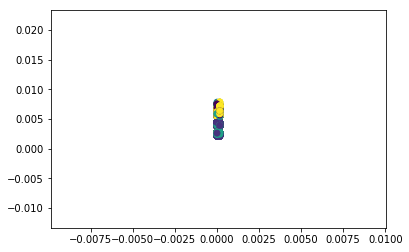

Time: 1.6678528785705566 seconds 
Comparing k-means clusters against the data:
author_id  1090547  1110391  1135724  1197086  1363719  1486619  1496664  \
row_0                                                                      
0                0       13        7        0       12        0        6   
1                1       20        0        2        0        0        0   
2                0        0        1        0        1        0        1   
3                0        0        0        0        0        0        1   
4                0       19       12        2       14        2       11   
5                0        1        1        0        4        0        6   
6                0        0        0        0        0        0        0   
7                0        0       22        0       59       39       28   

author_id  1533236  1594483  1627914  ...   4305123  4312837  4322781  \
row_0                                 ...                               
0             

In [46]:

start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=8, random_state=42).fit_predict(X_train_norm)

# Plot the solution.
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train))

8 clusters looks a little bit better because the authors for the most part are only spread across 1 or 2 clusters. Let's try mean shift and then move on with whichever is better -  kmeans with 8 clusters, or meanshift.

In [47]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_norm, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 2


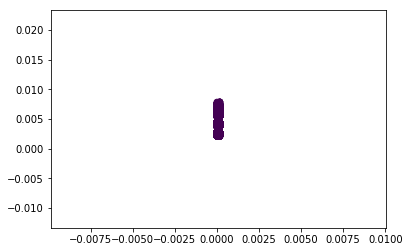

Comparing the assigned categories to the ones in the data:
col_0        0  1
author_id        
1090547      1  0
1110391     53  0
1135724     43  0
1197086      4  0
1363719     90  0
1486619     41  0
1496664     53  0
1533236     17  0
1594483    106  0
1627914     60  0
1633534    176  0
1695621     35  0
1716133     22  0
1725978     31  0
1730043      6  0


In [48]:
plt.scatter(X_train_norm[:, 0], X_train_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels).head(15))

This is not really better than kmeans with 8 clusters, from a quick glance.

In [49]:
clusters = ms.labels_.tolist()

In [50]:
print(len(clusters), set(clusters))

4590 {0, 1}


In [51]:
# put the clusters genereated from the Mean shift algorithm into the dataframe so we
# can analyze the clusters a little better
X_train['cluster'] = clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:

X_train['kmeans_cluster'] = kmeans_clusters

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
X_train.head()

,gender,age,month,day,year,industry_Accounting,industry_Architecture,industry_Arts,industry_Automotive,industry_Banking,...,ask,play,watch,keep,write,another,many,man,cluster,kmeans_cluster
3169,0,27,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4958,1,39,7,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
552,1,24,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1177,1,36,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4085,0,38,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [54]:
df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,maybe,school,ask,play,watch,keep,write,another,many,man
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1979283,1,27,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '...",5,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,1979283,1,27,I've been spending many hours getting my ears ...,"(I, 've, been, spending, many, hours, getting,...",5,0,1,0,0,...,0,0,0,2,0,0,0,0,1,0
4,1979283,1,27,Getting this SEO shit up is really getting on ...,"(Getting, this, SEO, shit, up, is, really, get...",5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Part 4 - Features and models

I'm going to generate some more features using unsupervised techniques and then try to use some models.

In [55]:
# ok so recap, X_train is the X_train withOUT normalization 

X_train.head(3)

,gender,age,month,day,year,industry_Accounting,industry_Architecture,industry_Arts,industry_Automotive,industry_Banking,...,ask,play,watch,keep,write,another,many,man,cluster,kmeans_cluster
3169,0,27,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4958,1,39,7,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
552,1,24,7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


###  tf-idf  (vectors for each post)

We already got a single span vector with the supervised learning technique, but I'll also try it using an unsupervised learning technique.

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer(max_df=0.75, # drop words that occur in more than 75 percent of the paragraphs
                             min_df=5, # only use words that appear at least n times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
lines_tfidf=vectorizer.fit_transform(df['post'])
print("Number of features: %d" % lines_tfidf.get_shape()[1])

# inititally tried model with parameters: max_df 0.75, min_df 10, # of features was 187

Number of features: 10483


In [57]:
print(lines_tfidf.shape)

(6121, 10483)


In [58]:
terms = vectorizer.get_feature_names()

In [59]:
lines_csr = lines_tfidf.tocsr()

In [60]:
#number of paragraphs
n = lines_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*lines_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = lines_csr[i, j]

In [61]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was
# present once in that sentence.
for i in range(3):
    print('Original sentence:', df.loc[i,'post'])
    print('Tf_idf vector:', tfidf_bypara[i])

Original sentence: funny how 10 minutes seem like forever...i need a smoke
Tf_idf vector: {'funny': 0.37022251551419283, '10': 0.35105417091159236, 'minutes': 0.3806776313670958, 'like': 0.1856462388704743, 'forever': 0.42134248506548483, 'need': 0.28225658625971833, 'smoke': 0.550561534121077}
Original sentence: Had problems posting again. Thanks to the people at SureSupport.com for helping me out! :) Took them less than 15 minutes to fix everything..great service! now if only I can say the same for Wendy's...
Tf_idf vector: {'minutes': 0.2383494462427692, 'problems': 0.2680033051599549, 'posting': 0.30978781110135073, 'thanks': 0.24851031518479527, 'people': 0.1470519119573764, 'com': 0.22824153971073147, 'helping': 0.3370220891773829, 'took': 0.21764426576671733, '15': 0.2655205725866367, 'fix': 0.32227368539875384, 'great': 0.1808881436310727, 'service': 0.28233042074489845, 'say': 0.1602784908222763, 'wendy': 0.4080255391426403}
Original sentence: Finally got this to work..so here

In [62]:
 # dimension reduction
    
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 4931 to the number below.
svd= TruncatedSVD(1500)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
lines_lsa = lsa.fit_transform(lines_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(lines_lsa, #index=df['post']
                               )
#for i in range(5):
#    print('Component {}:'.format(i))
#    print(paras_by_component.loc[:50,i].sort_values(ascending=False)[0:5])   

Percent variance captured by all components: 70.3690822726446


In [63]:
paras_by_component.head(3)

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.113841,-0.030653,0.030772,0.012901,0.050410,0.007435,-0.113117,-0.002766,-0.082931,-0.084666,...,0.001705,0.019690,-0.000256,0.017158,0.008675,-0.000708,0.017829,-0.000997,0.017852,-0.003114
1,0.098053,-0.008943,-0.031406,-0.041144,-0.068103,0.086724,-0.015345,0.028923,-0.030920,0.048063,...,0.014084,-0.009463,0.007573,-0.023566,-0.014540,0.013620,-0.002886,0.004679,-0.006380,-0.020296
2,0.266311,0.463207,0.028190,-0.033590,-0.024556,0.052511,0.044608,0.045930,0.062644,0.039871,...,-0.007548,-0.012133,-0.007950,-0.012839,0.006505,0.024193,-0.041098,0.042418,-0.006544,0.007596


In [64]:
# add the components back into the dataframe as features

df = df.reset_index(drop=True)
paras_by_component = paras_by_component.reset_index(drop=True)

df = df.join(paras_by_component)

df.head()

,author_id,gender,age,post,parsed,month,day,year,industry_Accounting,industry_Architecture,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,...",5,0,0,0,0,...,0.001705,0.019690,-0.000256,0.017158,0.008675,-0.000708,0.017829,-0.000997,0.017852,-0.003114
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,...",5,0,0,0,0,...,0.014084,-0.009463,0.007573,-0.023566,-0.014540,0.013620,-0.002886,0.004679,-0.006380,-0.020296
2,1979283,1,27,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '...",5,0,0,0,0,...,-0.007548,-0.012133,-0.007950,-0.012839,0.006505,0.024193,-0.041098,0.042418,-0.006544,0.007596
3,1979283,1,27,I've been spending many hours getting my ears ...,"(I, 've, been, spending, many, hours, getting,...",5,0,1,0,0,...,0.010836,-0.004084,-0.010130,-0.032193,0.039374,0.002706,-0.005936,0.018225,-0.022244,0.008211
4,1979283,1,27,Getting this SEO shit up is really getting on ...,"(Getting, this, SEO, shit, up, is, really, get...",5,0,0,0,0,...,0.023395,-0.017363,0.001127,0.014610,0.008180,0.011364,0.000187,-0.011568,0.019174,-0.007567


Document similarity

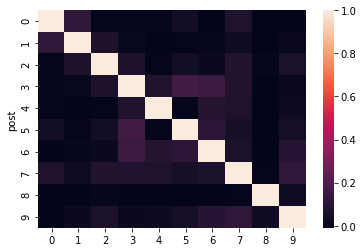

Key:
0 funny how 10 minutes seem like forever...i need a smoke
1 Had problems posting again. Thanks to the people at SureSupport.com for helping me out! :)
2 Finally got this to work..so here's my first weblog. Pop the cork and blow the horn! Who a
3 I've been spending many hours getting my ears (and hands) wet playing urlLink EA Sports NB
4 Getting this SEO shit up is really getting on my nerves...
5 Not bad for my first airsoft game in over 3 months! I was panting and wheezing the first f
6 Somehow losing to a school other than DLSU doesn't hurt as much. Getting stuck in traffic 
7 Bad day. Seems like my staying up late for work these past few days has finally caught up 
8 Ateneo wins over La Salle...ONE BIG FIGHT! :)
9 urlLink Alleluia ! Last weekend was a whirlwind. Woke up early for a wedding and twas my f


In [65]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(lines_lsa) * np.asmatrix(lines_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=df['post']).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i][:90])

In [66]:
print(similarity.shape, df.shape)


(6121, 6121) (6121, 1697)


In [67]:
df.iloc[:3,:5]

,author_id,gender,age,post,parsed
0,1979283,1,27,funny how 10 minutes seem like forever...i nee...,"(funny, how, 10, minutes, seem, like, forever,..."
1,1979283,1,27,Had problems posting again. Thanks to the peop...,"(Had, problems, posting, again, ., Thanks, to,..."
2,1979283,1,27,Finally got this to work..so here's my first w...,"(Finally, got, this, to, work, .., so, here, '..."


In [68]:
# add the features back to the training and test sets

X_train = X_train.join(df.iloc[:,200:])
X_test = X_test.join(df.iloc[:,200:])

## models

a - gradient boosting

In [69]:
from sklearn.model_selection import cross_val_score

In [70]:
from sklearn import ensemble

In [71]:
#X_train_smaller = withbin.drop(['post','parsed'], 1)
#y_train

# training on smaller portions of X_train so I can test it on itself

X_train_smaller, X_test_smaller, y_train_smaller, y_test_smaller = train_test_split(X_train,
                                                                y_train, test_size=.25)

In [72]:
# with defaults - Training set score: 0.00846262341325811
#Test set score: 0.004739336492890996

clf = ensemble.GradientBoostingClassifier(n_estimators=200)


In [73]:
clf.fit(X_train_smaller, y_train_smaller)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [74]:
training_score = clf.score(X_train_smaller, y_train_smaller)

In [75]:
# need to get the clusters before i can run this
testing_score = clf.score(X_test_smaller, y_test_smaller)


In [76]:
print('Training set score:', training_score)
print('\nTest set score:', testing_score)

Training set score: 0.9837303893085415

Test set score: 0.6019163763066202


In [77]:
scores = cross_val_score(clf, X_train,y_train,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.65 (+/- 0.07)


In [78]:
scores_clf = cross_val_score(clf,X_train_smaller,y_train_smaller,cv=5)

print("Accuracy: %0.2f (+/- %0.2f)"% (scores_clf.mean(), scores_clf.std() *2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.64 (+/- 0.08)


b - logistic regression

In [79]:
from sklearn.linear_model import LogisticRegression

In [80]:
lr = LogisticRegression()

train = lr.fit(X_train_smaller, y_train_smaller)


In [81]:
lr.score(X_train_smaller,y_train_smaller)

0.9947704822777454

In [82]:
lr.score(X_test_smaller, y_test_smaller)

0.7421602787456446

In [83]:
scores_lr_ts = cross_val_score(lr, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores_lr_ts.mean(), scores_lr_ts.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.69 (+/- 0.31)


c. random forest

In [84]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(X_train_smaller,y_train_smaller)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [85]:
train = rfc.score(X_train_smaller,y_train_smaller)

In [86]:
test = rfc.score(X_test_smaller,y_test_smaller)

In [87]:
print('Training set score:', train)
print('\nTest set score:', test)

Training set score: 0.9985473561882626

Test set score: 0.5766550522648084


In [88]:
scores_rfc = cross_val_score(rfc, X_test_smaller,y_test_smaller,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc.mean(), scores_rfc.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.50 (+/- 0.33)


# Part 5 - back to holdout group

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

### clustering on holdout group

first i need to normalize the data

In [89]:
X_test_norm = normalize(X_test)

K Means

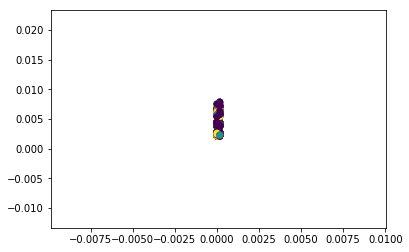

Time: 1.52996826171875 seconds 
Comparing k-means clusters against the data:
author_id  1090547  1110391  1135724  1197086  1363719  1486619  1496664  \
row_0                                                                      
0                0        9        8        1       17       11       15   
1                0        0        0        0        1        0        3   
2                1        5        2        0        9        0        4   

author_id  1533236  1594483  1627914  ...   4293254  4293657  4305123  \
row_0                                 ...                               
0                7       13       17  ...         3        3        2   
1                0        1        1  ...         0        0        0   
2                0       26        3  ...         2        0        0   

author_id  4322781  4323865  4325889  574985  579034  851693  9289  
row_0                                                               
0                1        1        3  

In [90]:
start = time()
# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_test_norm)

# Plot the solution.
plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=y_pred)
plt.show()

print('Time: {} seconds '.format(time()-start))
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_test))

# going to add the info back into the dataframe later
kmeans_clusters = y_pred

Mean shift

Number of estimated clusters: 2


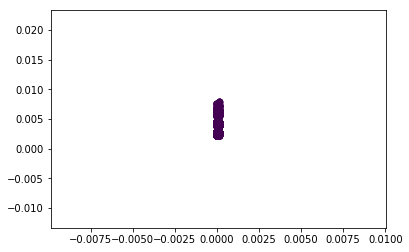

Comparing the assigned categories to the ones in the data:
col_0       0  1
author_id       
1090547     1  0
1110391    14  0
1135724    10  0
1197086     1  0
1363719    27  0
1486619    11  0
1496664    22  0
1533236     7  0
1594483    40  0
1627914    21  0
1633534    66  0
1695621     5  0
1716133    13  0
1725978    14  0
1730043     4  0


In [91]:
ms.fit(X_test_norm)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

plt.scatter(X_test_norm[:, 0], X_test_norm[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_test,labels).head(15))


In [92]:
clusters = ms.labels_.tolist()

In [93]:
# add the clusters as features for the next step

X_test['cluster'] = clusters
X_test['kmeans_cluster'] = kmeans_clusters

## modelling

same steps to add the features, then using the previously fit models on the holdout data to see how it works

In [94]:
#X_test.columns.values

The model below won't work because a column is missing. Let's see what it is and add it if that is feasible.

In [95]:
#test_cols = X_test_bin.columns.values
#with_cols = withbin.columns.values

#for col in with_cols:
#    if col not in test_cols:
#        print(col)

In [96]:
# X_test_bin['industry_Advertising'] = 0

gradient boosting


In [97]:
new_testing_score = clf.score(X_test, y_test)

print('Holdout score:', new_testing_score)

Holdout score: 0.5858915741345526


In [98]:
scores_gb = cross_val_score(clf,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/-  %0.2f)" % (scores_gb.mean(), scores_gb.std()*2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.60 (+/-  0.23)


logistic regression

In [99]:
lr.score(X_test, y_test)

0.7615937295885042

In [100]:
lr_cv = cross_val_score(lr,X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (lr_cv.mean(), lr_cv.std() * 2 ))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.70 (+/- 0.27)


random forest

In [101]:
rfc.score(X_test,y_test)

0.4951012410189419

In [102]:
scores_rfc_t = cross_val_score(rfc, X_test,y_test,cv=10)

print("Accuracy: %0.2f (+/- %0.2f)" % (scores_rfc_t.mean(), scores_rfc_t.std() * 2))

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Accuracy: 0.51 (+/- 0.23)


In [103]:
# gradient boosting, logistic regression, random forest

results = pd.DataFrame(index=["test score", "std"])

results["gradient boosting"] = [scores_clf.mean(), scores_clf.std()*2]
results["logistic regression"] = [scores_lr_ts.mean(), scores_lr_ts.std()*2]
results["random forest"] = [scores_rfc.mean(), scores_rfc.std()*2]


In [104]:
results

,gradient boosting,logistic regression,random forest
test score,0.636153,0.688228,0.504947
std,0.076750,0.311537,0.325635


<hr width="50%" />

### Conclusion

The clusters generated on the test group seem the most different when comparing the test group to the training group, possibly because the amount of data is so much less, and as a result the variance and distinct features are also less.

The models are not especially great for both the training and testing groups. It looks like they are either overfit or have a lack of accuracy that is concerning and makes their usefulness questionable.

When comparing clustering to modeling, in terms of classifying these texts, it appears like modelling is better for isolating specific features and would be good if you had an idea of what specific features would be most useful to generate, or if you had the patience to do that.

Clustering on the other hand was approximately as accurate but didn't require knowing much about the contents of the posts in order to organize them by author.

In consideration of that, I think in this case clustering was the best method, because it didn't require knowledge of the contents of the text. However, I imagine if someone did have an idea of the contexts of the text, they would be able to generate more specifically targeted features, and potentially in that case, modelling could perform significantly better.

